In [27]:
import importlib
import tensorflow as tf
import utils
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
importlib.reload(utils)

AUGMENTED_DATA_PATH = "../TUBITAK/datasets/CSV_Multi_Label_Classification_Augmented"
tf.test.is_built_with_cuda()

True

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.
    except RuntimeError as e:
        print(e)


In [23]:
#dataset-load
train_df = utils.load_data("train", AUGMENTED_DATA_PATH)
test_df = utils.load_data("test", AUGMENTED_DATA_PATH)
valid_df = utils.load_data("valid", AUGMENTED_DATA_PATH)
#tensor dataset transform
augmented_train_dataset = utils.create_dataset(train_df)
augmented_valid_dataset = utils.create_dataset(valid_df)
augmented_test_dataset = utils.create_dataset(test_df)

In [15]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.trainable = False

87910968/87910968 [==============================] - 21s 0us/step


In [18]:
#base model -> model (özel katmanlar eklenerek kendi modelimizi oluştururuz)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Yeni model oluştur
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

In [25]:
my_callbacks= [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=8,#x epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True# En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.5,# Öğrenme oranını %x azalt
        patience=3,# x epoch boyunca iyileşme olmazsa lr düşür
        min_lr=1e-6 # En düşük learningrate oranı
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_GoogleNet_model.h5",
        monitor='val_loss',
        save_best_only=True,#en düşük val_loss olduğunda kaydet.
        mode='min',
    )
]

In [26]:
history = model.fit(
    augmented_train_dataset,
    validation_data=augmented_valid_dataset,
    batch_size=64,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30
530/530 [==============================] - 91s 154ms/step - loss: 0.6639 - accuracy: 0.7361 - val_loss: 0.5135 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 2/30
530/530 [==============================] - 77s 145ms/step - loss: 0.3834 - accuracy: 0.8494 - val_loss: 0.4700 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 3/30
530/530 [==============================] - 77s 145ms/step - loss: 0.2820 - accuracy: 0.8900 - val_loss: 0.4970 - val_accuracy: 0.8115 - lr: 0.0010
Epoch 4/30
530/530 [==============================] - 76s 144ms/step - loss: 0.2211 - accuracy: 0.9121 - val_loss: 0.5045 - val_accuracy: 0.8315 - lr: 0.0010
Epoch 5/30
530/530 [==============================] - 76s 144ms/step - loss: 0.1965 - accuracy: 0.9228 - val_loss: 0.6421 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 6/30
530/530 [==============================] - 76s 144ms/step - loss: 0.1486 - accuracy: 0.9441 - val_loss: 0.6093 - val_accuracy: 0.8321 - lr: 5.0000e-04
Epoch 7/30
530/530 [============================

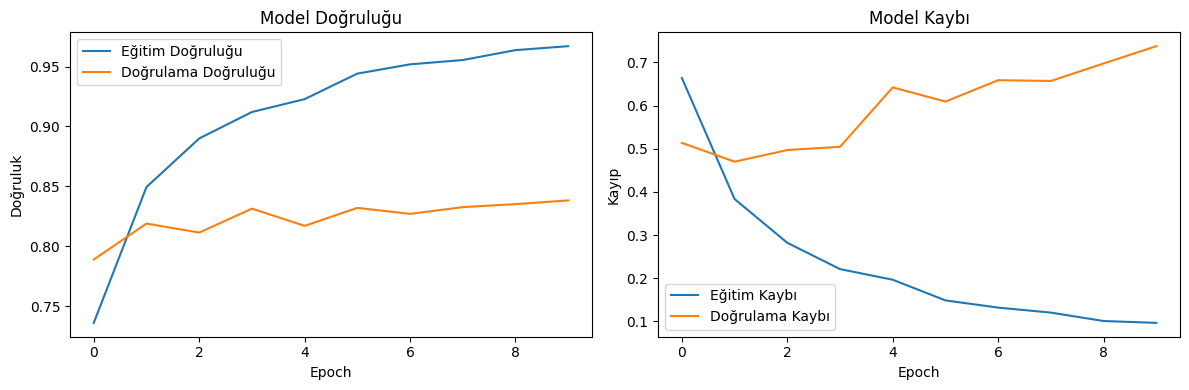

In [28]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.7889
F1 Score: 0.7996
ROC-AUC Score: 0.9314


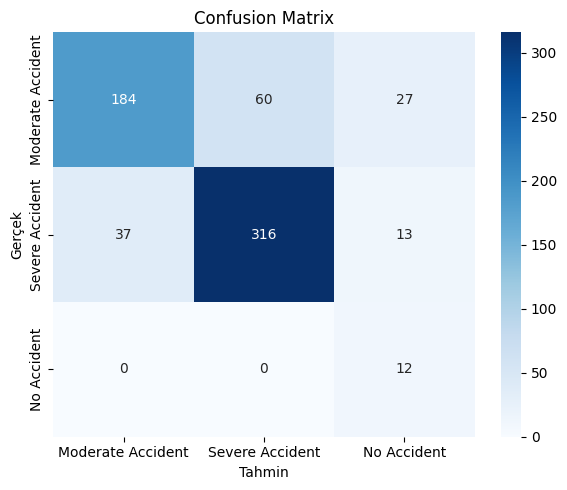


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.83      0.68      0.75       271
  Severe Accident       0.84      0.86      0.85       366
      No Accident       0.23      1.00      0.38        12

         accuracy                           0.79       649
        macro avg       0.63      0.85      0.66       649
     weighted avg       0.83      0.79      0.80       649



In [29]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, augmented_test_dataset, class_names)